# Inputs

In [1]:
version = 'vr2'
V = {}

In [2]:
V['x'] = '0.999687516276*(x_dut[0] - 15.5714285714) + -0.0249973959147*(y_dut[0] - 25.3428571429) + 15.5714285714'
V['y'] = '0.999687516276*(y_dut[0] - 25.3428571429) - -0.0249973959147*(x_dut[0] - 15.5714285714) + 25.3428571429'

In [3]:
selection = '(amp[15] != 0 && integral[15] != 0) && (amp[15]>881.068666649 && amp[15]<953.68955555) && ntracks==1 && chi2<5 && (amp[9] != 0 && integral[9] != 0) && (-integral[9]>1.56887276438 && -integral[9]<5.05859256206) && ntracks==1 && chi2<5 && (amp[9] != 0 && integral[9] != 0) && (-integral[9]>1.56887276438 && -integral[9]<5.05859256206) && ntracks==1 && chi2<5 && LP1_50[15] != 0 && (0.999687516276*(y_dut[0] - 25.3428571429) - -0.0249973959147*(x_dut[0] - 15.5714285714) + 25.3428571429 < 28.8857142857 && 0.999687516276*(y_dut[0] - 25.3428571429) - -0.0249973959147*(x_dut[0] - 15.5714285714) + 25.3428571429 > 21.8 && 0.999687516276*(x_dut[0] - 15.5714285714) + -0.0249973959147*(y_dut[0] - 25.3428571429) + 15.5714285714 < 21.1714285714 && 0.999687516276*(x_dut[0] - 15.5714285714) + -0.0249973959147*(y_dut[0] - 25.3428571429) + 15.5714285714 > 9.97142857143) && (amp[25] != 0 && integral[25] != 0) && (amp[25]>457.500358489 && amp[25]<563.888419649) && ntracks==1 && chi2<5 && (amp[9] != 0 && integral[9] != 0) && (-integral[9]>1.56887276438 && -integral[9]<5.05859256206) && ntracks==1 && chi2<5&& (LP1_50[15] - gaus_mean[9] < -4.44639110565 && LP1_50[15] - gaus_mean[9] > -5.22873592377)'
dt_lim = [-5.22873592377, -4.446]

In [4]:
V['dT'] = 'LP1_50[15] - gaus_mean[9]'
V['amp'] = 'amp[25]'

In [40]:
N_bins = [20,20]
res_x = 1.
res_y = 1.
width = 8

# Preamble

In [6]:
import numpy as np
import os, re, shutil, time
import argparse
import itertools
from prettytable import PrettyTable
import matplotlib.pyplot as plt

import ROOT as rt
from root_numpy import tree2array, tree2rec
from lib.histo_utilities import create_TH1D, create_TH2D, quantile, create_prof1D, EstimateDispersion, rootTH2_to_np
from lib.cebefo_style import cebefo_style, Set_2D_colz_graphics
cebefo_style()
rt.gErrorIgnoreLevel = 6000

Welcome to JupyROOT 6.12/06


In [7]:
file_template = '../data/VME/RECO/'+version+'/DataVMETiming_RunXXX.root'
infile = '../results/'+version+'/TracksConsistency_Good.txt'

In [8]:
runs = np.sort(np.loadtxt(infile).astype(np.int))
runs = list(runs)
input_file = map(lambda x: file_template.replace('XXX', str(x)), runs)

chain = rt.TChain('pulse')
for f in input_file:
    chain.Add(f)

In [9]:
data_raw = tree2array(chain, V.values(), selection).view(np.recarray)
data = np.zeros((data_raw.shape[0], len(data_raw[0])))
data_struct = []

for iev, d in enumerate(data_raw):
    data[iev] = [d[0], d[1], d[2][0], d[3][0]]
    data_struct.append((d[0], d[1], d[2][0], d[3][0]))


dtypes = zip(V.keys(), len(V.keys())*['f8'])
sdata = np.array(data_struct, dtype=dtypes)

In [10]:
sdata['x'] -= (np.min(sdata['x']) + np.max(sdata['x']))/2.
sdata['y'] -= (np.min(sdata['y']) + np.max(sdata['y']))/2.

### Noise check

In [11]:
bt = 'baseline_RMS[{}]'
for b in [bt.format(i) for i in [9, 15, 25]]:
    arr = tree2array(chain, b, selection).view(np.recarray).flatten()
    print '{} = {:.1f} +/- {:.1f} mV'.format(b, np.mean(arr), np.std(arr))

baseline_RMS[9] = 1.1 +/- 0.3 mV
baseline_RMS[15] = 9.3 +/- 8.9 mV
baseline_RMS[25] = 0.9 +/- 0.2 mV


# Making the plots

In [20]:
def MakeSumLR_prof_plot(dt, x, y, tag, lim=None, draw_opt='', prof_opt='', units='ns'):
    unique_id = str(int(100*time.time()))
    rt.gStyle.SetHistLineWidth(2)
    can = rt.TCanvas('c_'+unique_id, 'c', 400, 500)
    leg = rt.TLegend(0.62,0.68,0.98,0.93)
    can.obj = [leg]
    
    colors = [rt.kBlue, rt.kCyan, rt.kGreen, rt.kOrange, rt.kRed]
    for i_s, (yd, yu) in enumerate(zip(y_sec[:-1], y_sec[1:])):
        sel = np.logical_and(y<yu, y>yd)
        
        h = create_prof1D(x[sel], dt[sel], name='h_{}_{}'.format(i_s, unique_id), 
                          title=tag+' in selected events', 
                          binning=[N_bins[0], -width, width], 
                          axis_title = ['x [mm]',tag+' ['+units+']'],
                          opt=prof_opt)
        h.SetLineColor(colors[i_s])
        h.SetMarkerColor(colors[i_s])
        h.SetStats(0)
        if i_s == 0 and lim != None:
            h.GetYaxis().SetRangeUser(lim[0], lim[1])
            h.GetYaxis().SetTitleOffset(1.8)
        
        opt = ''
        if i_s != 0:
            opt += 'SAME'
        h.Draw(opt)
        leg.AddEntry(h, ' y #in [{:.1f}, {:.1f}]'.format(yd, yu), 'l')
        can.obj.append(h)
        
    leg.Draw()
    rt.gPad.SetLeftMargin(0.17)
    return can

In [21]:
def MakeSumLR_hist_plot(dt, tag, lim=None, draw_opt='', weights=None):
    unique_id = str(int(100*time.time()))
    rt.gStyle.SetHistLineWidth(2)
    h = create_TH1D(dt, name='h_'+unique_id,
                    title=tag+' in selected events', 
                    binning=[2*N_bins[0], np.min(dt), np.max(dt)], 
                    axis_title = [tag+' [ns]', 'Events'],
                    weights=weights
                    )
    h.SetStats(0)
    h.Sumw2()
    if lim != None:
        h.GetYaxis().SetRangeUser(lim[0], lim[1])
    h.GetYaxis().SetTitleOffset(1.5)
    
    can = rt.TCanvas('c_'+unique_id, 'c', int(800*2/3.), int(600*2/3.))

    h.SetLineColor(1)
    h.Draw(draw_opt)
    s, ds = EstimateDispersion(1e3*dt, w=weights)
    l = rt.TLatex()
    l.SetTextSize(0.05)
    l.DrawLatexNDC(0.2, 0.85, 'Dispersion: {:.1f} #pm {:.1f} ps'.format(s, ds))

    rt.gPad.SetLeftMargin(0.16)
    can.obj = [h]
    return can

In [22]:
def plot_it(dt, lims = [None, None, None], weights=None):
    if lims[0] == None:
        lims[0] = dt_lim
    c = MakeSumLR_prof_plot(dt, sdata['x'], sdata['y'], 'Average time stamp', lim=lims[0])
    
    if lims[1] == None:
        lims[1] = [0,120]
    c2 = MakeSumLR_prof_plot(1e3*dt, sdata['x'], sdata['y'], 
                             'Time resolution', lim=lims[1], prof_opt='Res',
                            units='ps')

    c_tot = rt.TCanvas('c_tot', 'c_tot', 800, 500)
    c_tot.Divide(2,1)
    c_tot.cd(1)
    c.DrawClonePad()
    c_tot.cd(2)
    c2.DrawClonePad()
    c_tot.Draw()

    c_res = MakeSumLR_hist_plot(dt, 'Time stamp', weights=weights)
    c_res.Draw()
    return c, c2, c_tot, c_res

In [23]:
def ApplyCorrections(dt, inputs):
    inputs = np.column_stack(tuple(inputs))
    coeff, r, rank, s = np.linalg.lstsq(inputs, dt, rcond=None)
    dt_corr = dt - np.dot(inputs, coeff)
    return dt_corr

### X-Y distribution

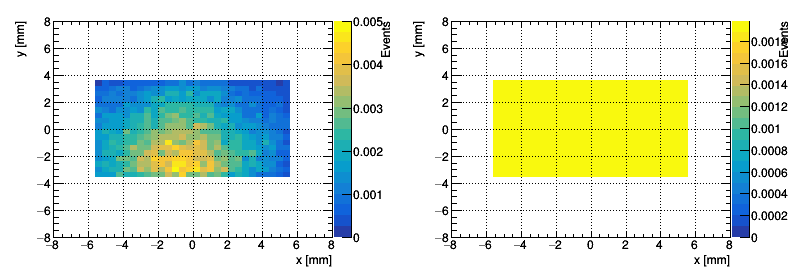

In [24]:
xy = np.column_stack((sdata['x'], sdata['y']))

h = create_TH2D(xy, 
                title='', 
                binning=[2*N_bins[0], -width, width, 2*N_bins[1], -width, width], 
                axis_title=['x [mm]', 'y [mm]', 'Events'])
h.SetStats(0)
h.Scale(1./h.GetEntries())

def GetAssBinContent(xy):
    ix = h.GetXaxis().FindBin(xy[0])
    iy = h.GetYaxis().FindBin(xy[1])
    return 1./h.GetBinContent(ix, iy)

w = np.array(map(GetAssBinContent, xy))
w *= w.shape[0]/np.sum(w)
h_w = create_TH2D(xy, title='', binning=h.binning, weights=w, axis_title=['x [mm]', 'y [mm]', 'Events'])
h_w.Scale(1./h_w.GetEntries())
h_w.SetStats(0)


c = rt.TCanvas('c', 'c', 800, 300)
c.Divide(2,1)
c.cd(1)
rt.gPad.SetRightMargin(0.15)
h.Draw('colz')
c.cd(2)
rt.gPad.SetRightMargin(0.15)
h_w.Draw('colz')
c.Draw()

w_norm = w/np.sum(w)

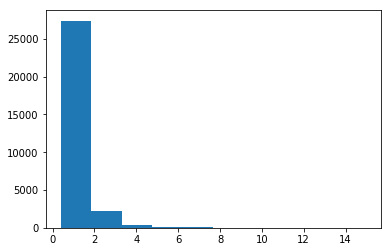

In [25]:
out = plt.hist(w, range=[np.min(w), np.max(w)])

### Amp + SiPM

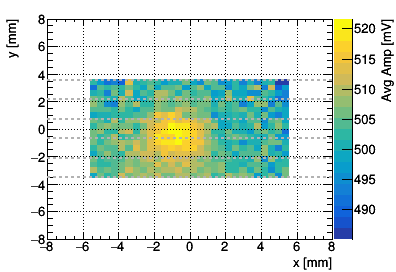

In [26]:
h = create_TH2D(xy, title='', 
                binning=[2*N_bins[0], -width, width, 2*N_bins[1], -width, width])

h_w = create_TH2D(xy, weights=sdata['amp'],
                title='', 
                binning=h.binning, 
                axis_title=['x [mm]', 'y [mm]', 'Avg Amp [mV]'])

h_w.Divide(h)
h_w.SetStats(0)
arr, pos = rootTH2_to_np(h_w)
h_w.GetZaxis().SetRangeUser(np.min(arr[arr>0]), np.max(arr))

c = rt.TCanvas('c', 'c', 400, 300)
h_w.Draw('colz1')
rt.gPad.SetRightMargin(0.16)
c.Draw()

y_sec, y_step = np.linspace(np.min(sdata['y']), np.max(sdata['y']), 6, retstep=True)
line = rt.TLine()
line.SetLineColor(16)
line.SetLineStyle(2)
line.SetLineWidth(2)
for i_s, (yd, yu) in enumerate(zip(y_sec[:-1], y_sec[1:])):
    line.DrawLine(-width, yu, width, yu)
    if i_s == 0:
        line.DrawLine(-width, yd, width, yd)

### Raw

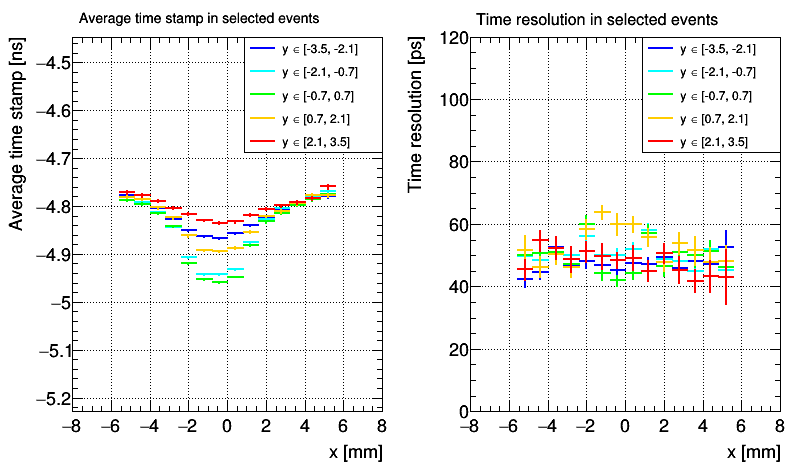

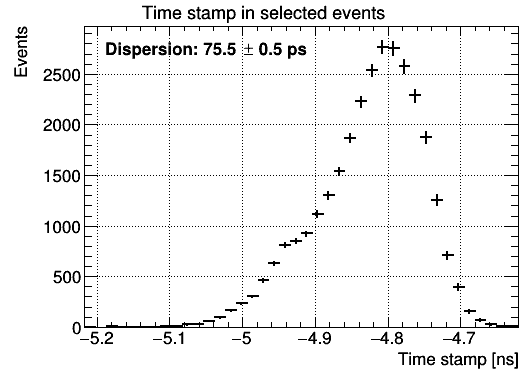

In [27]:
out = plot_it(sdata['dT'], weights=w)

### Global amp correction

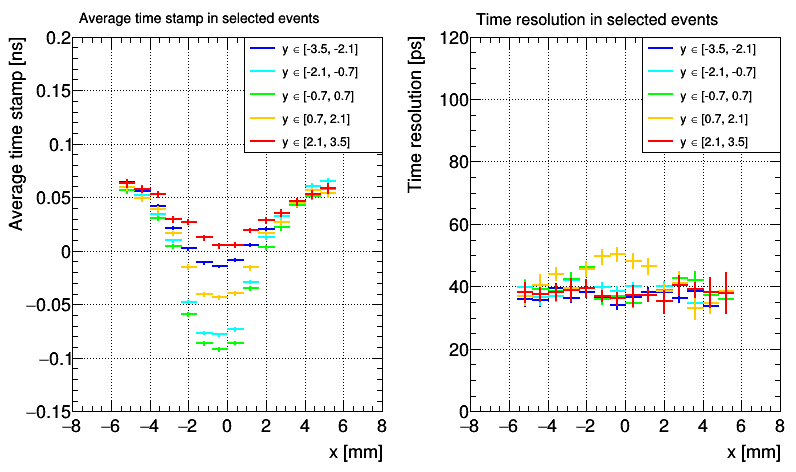

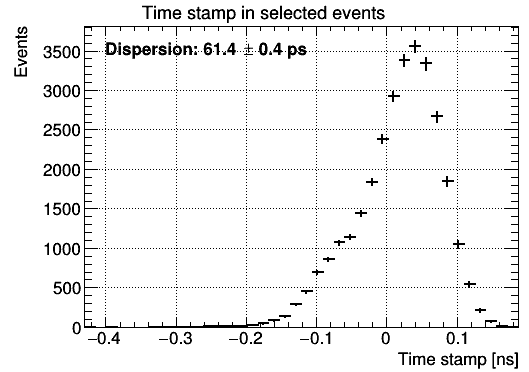

In [29]:
aux = [np.ones_like(sdata['dT']), sdata['amp'], np.square(sdata['amp'])]
dt = ApplyCorrections(sdata['dT'], aux)

out = plot_it(dt, lims = [[-0.15,0.2], None, None], weights=w)

### Global space correction

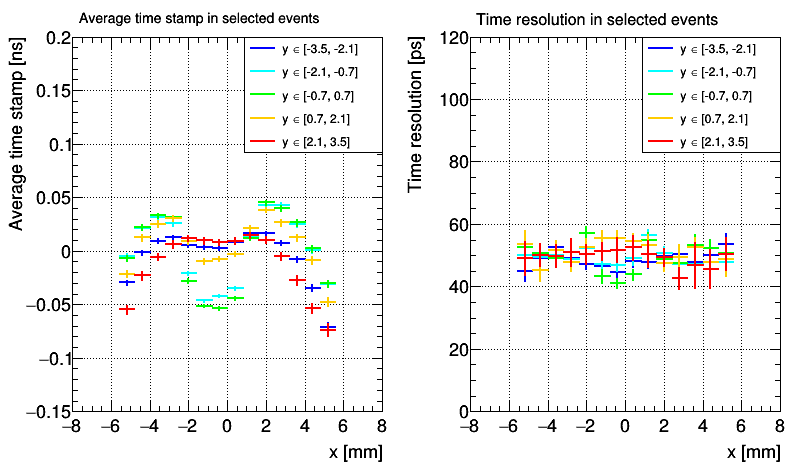

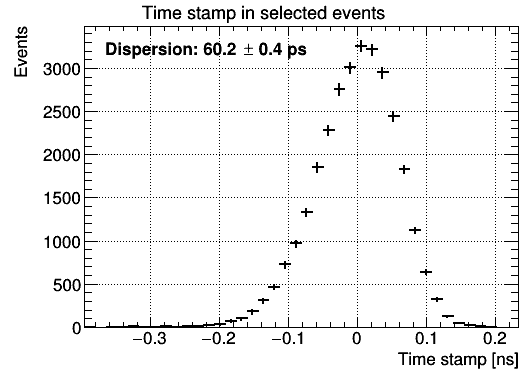

In [30]:
aux = [np.ones_like(sdata['dT']), 
       sdata['x'], np.square(sdata['x']),
       sdata['y'], np.square(sdata['y']),
       sdata['x']*sdata['y']
      ]
dt = ApplyCorrections(sdata['dT'], aux)

out = plot_it(dt, lims = [[-0.15,0.2], None, None], weights=w)

### Global amp and space correction

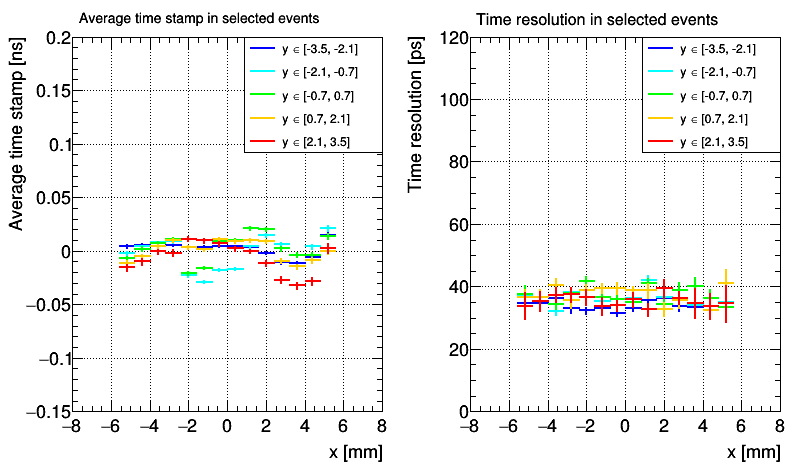

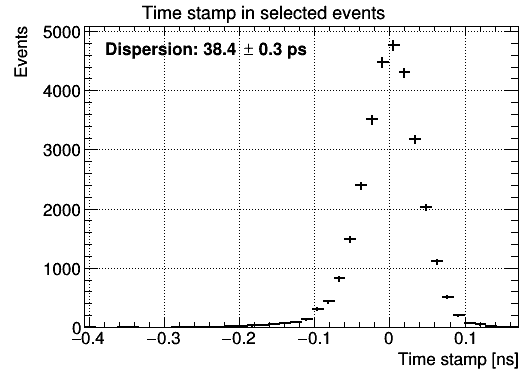

In [38]:
aux = [np.ones_like(sdata['dT']), 
       sdata['x'], np.square(sdata['x']), np.power(sdata['x'], 3), np.power(sdata['x'], 4),
       sdata['y'], np.square(sdata['y']), np.power(sdata['y'], 4),
       sdata['x']*sdata['y'],
#        np.hypot(sdata['x'], sdata['y']),
       sdata['amp'], np.square(sdata['amp']),
       sdata['amp']*np.hypot(sdata['x'], sdata['y']),
#        sdata['amp']*sdata['x'],
#        sdata['amp']*sdata['y'],
      ]
dt = ApplyCorrections(sdata['dT'], aux)

out = plot_it(dt, lims = [[-0.15,0.2], None, None], weights=w)

### Local amp correction

In [42]:
nx = (np.max(sdata['x']) - np.min(sdata['x']))/res_x
x_sec, x_step = np.linspace(np.min(sdata['x']), np.max(sdata['x']), 1+int(nx), retstep=True)

ny = (np.max(sdata['y']) - np.min(sdata['y']))/res_y
y_sec_aux, y_step_aux = np.linspace(np.min(sdata['y']), np.max(sdata['y']), 1+int(ny), retstep=True)

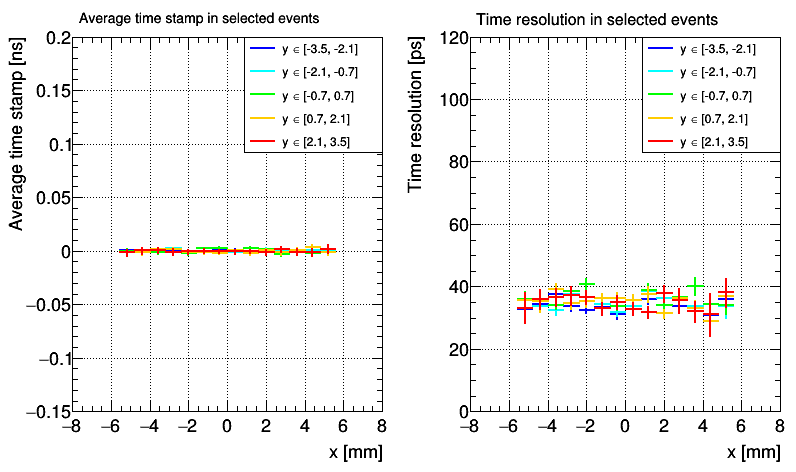

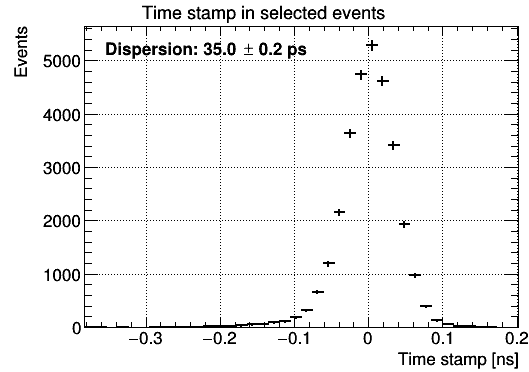

In [47]:
dt = np.zeros_like(sdata['dT'])
it = itertools.product(zip(x_sec[:-1], x_sec[1:]), zip(y_sec_aux[:-1], y_sec_aux[1:]))

for ib, ((xd, xu), (yd, yu)) in enumerate(it):
    selx = np.logical_and(sdata['x']>xd, sdata['x']<xu)
    sely = np.logical_and(sdata['y']>yd, sdata['y']<yu)
    sel = np.logical_and(selx, sely)
    
    if np.sum(sel) == 0:
        continue
    idxs = np.argwhere(sel).T
    
    aux = [np.ones_like(sdata['dT'])[sel], sdata['amp'][sel],
           np.square(sdata['amp'])[sel],
           sdata['x'][sel], sdata['y'][sel],
          ]
    dt[idxs] = ApplyCorrections(sdata['dT'][sel], aux)
    
out = plot_it(dt, lims = [[-0.15,0.2], None, None], weights=w)